In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.reset_option('display.max_rows')
#from IPython.display import display
#with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
#    display(df)
pd.set_option('display.max_colwidth',150)


**Creating a cutout**

In [3]:
#the cutout is delimited by a border drawn between Outer Hebrides, Kattegat, Strait of Dover as well as Shetland and Orkney Islands

cutout = atlite.Cutout(path="north-sea-region-march19.nc",
                       module="era5",
                       x=slice(-4.2600, 10.0000),
                       y=slice(51.4000, 60.8479),
                       time=slice("2019-03-01","2019-03-31")
                       )


In [4]:
cutout.prepare()

INFO:atlite.data:Cutout already prepared.


<Cutout "north-sea-region-march19">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.50 ⟷ 60.75, dy = 0.25
 time = 2019-03-01 ⟷ 2019-03-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [5]:
cutout.data
cutout.wind
cutout.prepared_features


<xarray.Dataset>
Dimensions:           (x: 58, y: 38, time: 744)
Coordinates:
  * x                 (x) float64 -4.25 -4.0 -3.75 -3.5 ... 9.25 9.5 9.75 10.0
  * y                 (y) float64 51.5 51.75 52.0 52.25 ... 60.25 60.5 60.75
  * time              (time) datetime64[ns] 2019-03-01 ... 2019-03-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(38,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(38, 58), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['temperature', 'influx', 'height', 'runoff', 'wind']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2022-12-14 18:30:28 GMT by grib_to_netcdf-2.25.1: /op...

<bound method wind of <Cutout "north-sea-region-march19">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.50 ⟷ 60.75, dy = 0.25
 time = 2019-03-01 ⟷ 2019-03-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']>

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                wnd_azimuth
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        influx           solar_altitude
        influx            solar_azimuth
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
dtype: object

**Importing country shapefiiles**

In [6]:
from shapely.geometry import Polygon
import geopandas

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
#Select the north sea bordering states
BorderingStates_init = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['United Kingdom', 'Denmark','Germany','Norway','France','Netherlands','Belgium']) 

cells = cutout.grid
projection = ccrs.Orthographic( -5,30)
country_bound = gpd.GeoSeries(cells.unary_union)

**Plotting the cutout with abstract land borders**

(-4.375, 51.375, 10.125, 60.875)

<GeoAxesSubplot:>

<GeoAxesSubplot:>

<GeoAxesSubplot:>

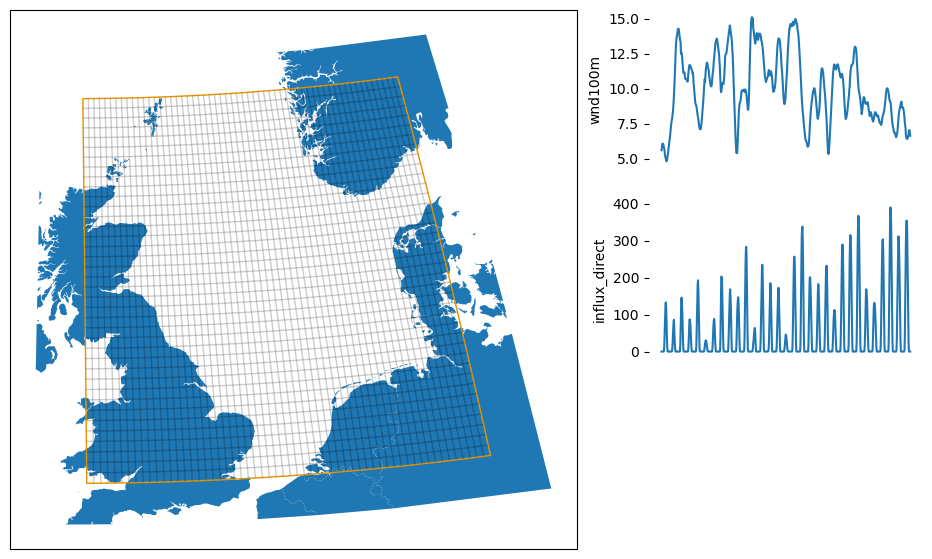

In [7]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig) 

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())

# we need to clip the predefined country border because they extend to Southern France and Svalbard

# a visual cutout of the north sea region is slightly larger than the actual cutout
display(cells.unary_union.bounds)
lat_point_list = [50.4,61.8479, 61.8479, 50.4,50.4]
lon_point_list = [-6.26, -6.26 , 12 ,12, -6.26 ]
polygon2 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf2 = gpd.GeoDataFrame([1], geometry=[polygon2], crs=cutout.grid.crs)
BorderingStates_init= BorderingStates_init.clip(poly_gdf2)

BorderingStates_init.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())

#ax.outline_patch.set_edgecolor('black')
ax.set_frame_on(True)
#a remnant of the tutorial: some weather data are plotted alongside
#so far, I want to keep the gridspec-layout
ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(['x', 'y']).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(['x', 'y']).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)


**Plotting the windfarms from EMODNet with a map from OpenStreetMap**

Text(0.5, 1.0, 'First step: All wind farms of north sea bordering states')

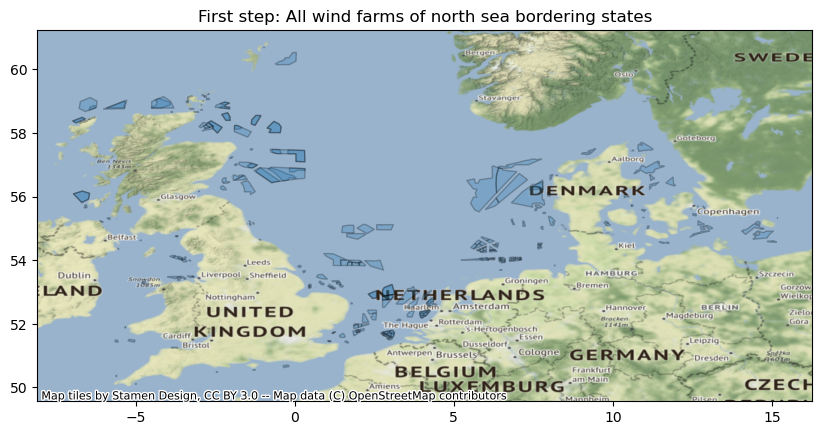

In [8]:
import contextily as cx

#data of European Offshore wind farms is imported
windfarm_map = gpd.read_file("../data/Windfarm-Shapefiles/EMODnet_HA_WindFarms_pg_20220324.shp")
# Firstly, we reduce the set to north sea bordering countries
windfarm_map=windfarm_map[windfarm_map["COUNTRY"].isin(['United Kingdom','Denmark','Belgium','Norway','Germany','Netherlands'])]

#contextily chooses the right zoom factor automatically
ax = windfarm_map.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_map.crs) # der passende Ausschnitt wird zugewiesen
ax.set_title("First step: All wind farms of north sea bordering states")

#strangely the suggested method in the documentation does not work
#windfarm_map.to_crs(epsg=3857)
#fig, ax = plt.subplots (figsize = (15,15))
#windfarm_map.plot(ax=ax)
#cx.add_basemap(ax=ax,crs= 3857)
#cx.add_basemap(ax)


The data contains necessarily wind farms beyond the North Sea due to country as a selection criterion.

**Plot only windfarms, that are located in the cutout**

Index(['OBJECTID', 'COUNTRY', 'NAME', 'N_TURBINES', 'POWER_MW', 'STATUS',
       'YEAR', 'COAST_DIST', 'AREA_SQKM', 'NOTES', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

,OBJECTID,COUNTRY,NAME,N_TURBINES,POWER_MW,STATUS,YEAR,COAST_DIST,AREA_SQKM,NOTES,Shape_Leng,Shape_Area,geometry
7,8,Belgium,Rentel,42,309.00,Production,2018,28354.728982,23.264154,None,0.260649,0.003017,"POLYGON ((2.88724 51.59085, 2.90552 51.59822, 2.91429 51.59965, 2.93139 51.60670, 2.93972 51.61086, 2.95537 51.61985, 3.00353 51.59084, 2.99282 51..."
8,9,Belgium,Norther,44,370.00,Production,2018,19797.758680,38.445331,None,0.352805,0.004979,"POLYGON ((3.04002 51.51200, 2.97331 51.48950, 2.93681 51.51286, 2.94508 51.51529, 2.97299 51.52806, 2.97883 51.53398, 2.98698 51.53413, 2.99118 51..."
9,10,Belgium,Seastar,30,252.00,Production,2020,36085.954019,18.426179,None,0.222749,0.002392,"POLYGON ((2.86386 51.61521, 2.84370 51.60708, 2.83087 51.60788, 2.81428 51.61465, 2.81934 51.61971, 2.83984 51.63631, 2.85773 51.65052, 2.86800 51..."
10,11,Belgium,Mermaid,28,235.20,Production,2020,48314.549431,16.676150,None,0.208196,0.002169,"POLYGON ((2.79057 51.71872, 2.78949 51.71814, 2.78900 51.71771, 2.78857 51.71722, 2.78790 51.71661, 2.78748 51.71613, 2.75580 51.71063, 2.75513 51..."
11,12,Belgium,C-Power (Zone A),24,141.15,Production,2013,24793.536916,10.682070,None,0.174694,0.001384,"POLYGON ((2.88360 51.54680, 2.90836 51.55810, 2.96208 51.53428, 2.93766 51.52309, 2.92797 51.52018, 2.88360 51.54680))"


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Second_step, All wind farms within the cutout')

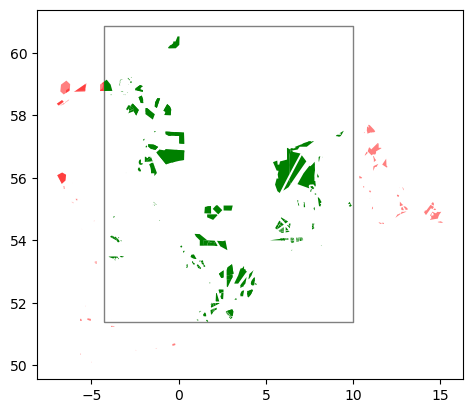

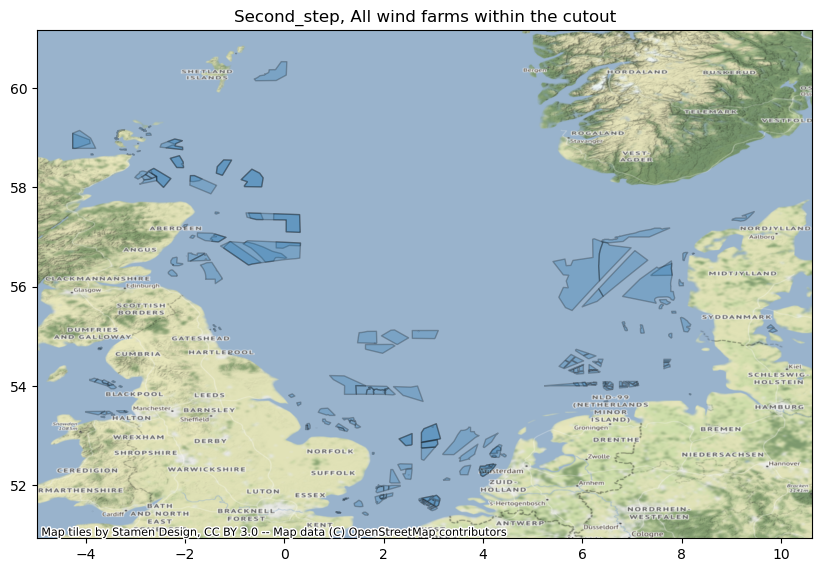

In [9]:
windfarm_map.columns
windfarm_map.head()

#take the polygon from the initial cutout and use it to reduce the initial country-based dataset
# a selection based on visual adherence to the region is not viable since the objectids have no geograpic correlation
#and the dataset containts more than 200 windfarms
lat_point_list = [51.4,60.8479, 60.8479,51.4,51.4]
lon_point_list = [-4.26, -4.26 , 10 ,10, -4.26 ]
polygon3 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf3 = gpd.GeoDataFrame([1], geometry=[polygon3], crs=windfarm_map.crs)

fig, (ax) = plt.subplots()
poly_gdf3.plot(ax=ax,color='white', edgecolor='grey')
windfarm_map.plot(ax=ax,zorder=0,color= 'red',alpha= 0.5)

windfarm_map_reduced = gpd.overlay(windfarm_map,poly_gdf3, how='intersection')
#that function also eliminates polygons outside of the scope of polygon 3 from our GeoPandas Dataframe
# but will also cut off border polygons 

#reindex took place automatically during overlay-method, else: df.reset_index()
#objectid serves as  unique identifiert
windfarm_map_reduced.plot(ax=ax,color='green')

#contextily plotting of windfarms on topographic map
ax = windfarm_map_reduced.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_map_reduced.crs) # der passende Ausschnitt wird zugewiesen
##ax.axis("off")
ax.set_title("Second_step, All wind farms within the cutout")

#display(windfarm_map_reduced)

**Discard windfarms, that are not located in the North Sea**

**i.e. off the coast of Cardif** : Bristol Channel <br> **in the Irish Sea** Liverpool Bay and Morecambe Bay

(224, 14)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Step Three: Exclusion of windfarms in Irish Sea/Cornwall and Baltic Sea')

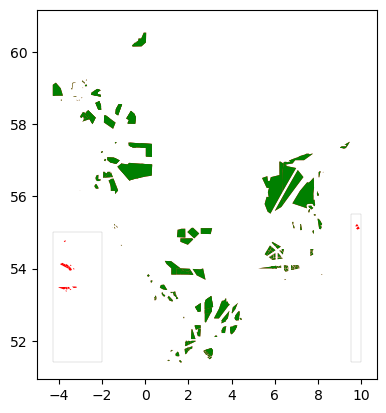

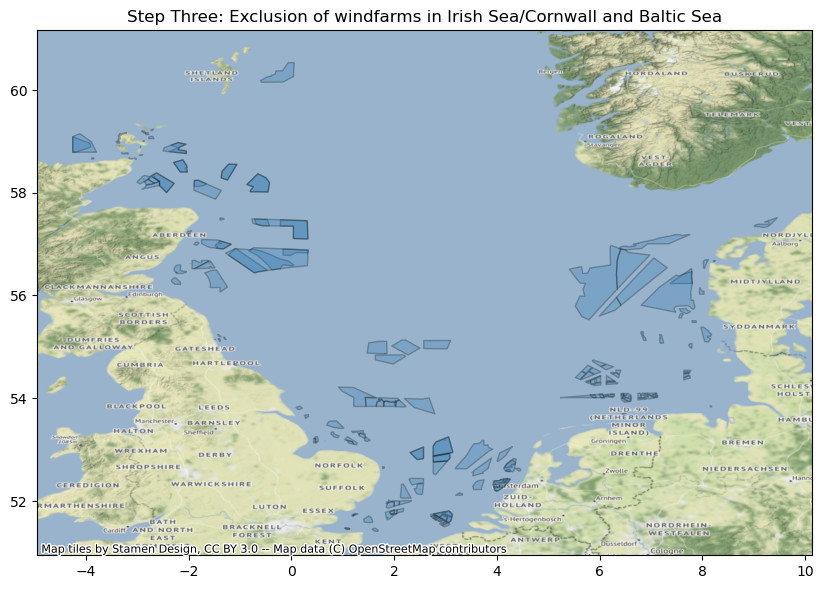

In [10]:

windfarm_map_reduced.shape

#define areas that are to be discarded
#again: selection is done by polygons instead of hand-selecting

#Irish Sea
lat_point_list = [51.4,55.0, 55.0,51.4,51.4]
lon_point_list = [-4.26, -4.26 , -2 ,-2, -4.26 ]
polygon4 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf_excl_west = gpd.GeoDataFrame([1], geometry=[polygon4], crs=windfarm_map_reduced.crs)

#Baltic Sea
lat_point_list = [51.4,55.5, 55.5,51.4,51.4]
lon_point_list = [9.5, 9.5 , 10 ,10, 9.5 ]
polygon5 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf_excl_east = gpd.GeoDataFrame([1], geometry=[polygon5], crs=windfarm_map_reduced.crs)

#within-function demands a gp-series, the argument needs to be a shapely-object
bool1= windfarm_map_reduced.within(polygon4) #ergibt eine Boolean-Tabelle
bool2= windfarm_map_reduced.within(polygon5)
#use boolean logic to create a mask that excludes both areas
bool3= bool1 + bool2

#windfarm_map_reduced
#use boolean filtering
windfarm_new= windfarm_map_reduced[~bool3.values]

#windfarm_map_reduced = windfarm_map_reduced[windfarm_map_reduced.within(polygon3) ==False]

fig,ax1 =plt.subplots()

windfarm_map_reduced.plot(ax=ax1,color='red',zorder=0)
windfarm_new.plot(ax=ax1,color='green')
poly_gdf_excl_east.plot(ax=ax1,color='none',edgecolor='grey',linewidth=0.15)
poly_gdf_excl_west.plot(ax=ax1,color='none',edgecolor='grey',linewidth=0.15)

#contextily plotting of windfarms on topographic map
ax = windfarm_new.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_new.crs) # der passende Ausschnitt wird zugewiesen
##ax.axis("off")
ax.set_title("Step Three: Exclusion of windfarms in Irish Sea/Cornwall and Baltic Sea")
#




In [11]:

windfarm_new.reset_index(drop=True, inplace=True)
windfarm_new.shape
windfarm_new


(204, 14)

,OBJECTID,COUNTRY,NAME,N_TURBINES,POWER_MW,STATUS,YEAR,COAST_DIST,AREA_SQKM,NOTES,Shape_Leng,Shape_Area,0,geometry
0,8,Belgium,Rentel,42,309.00,Production,2018,28354.728982,23.264154,None,0.260649,0.003017,1,"POLYGON ((2.90552 51.59822, 2.91429 51.59965, 2.93139 51.60670, 2.93972 51.61086, 2.95537 51.61985, 3.00353 51.59084, 2.99282 51.58800, 2.98329 51..."
1,9,Belgium,Norther,44,370.00,Production,2018,19797.758680,38.445331,None,0.352805,0.004979,1,"POLYGON ((2.97331 51.48950, 2.93681 51.51286, 2.94508 51.51529, 2.97299 51.52806, 2.97883 51.53398, 2.98698 51.53413, 2.99118 51.53645, 2.99906 51..."
2,10,Belgium,Seastar,30,252.00,Production,2020,36085.954019,18.426179,None,0.222749,0.002392,1,"POLYGON ((2.84370 51.60708, 2.83087 51.60788, 2.81428 51.61465, 2.81934 51.61971, 2.83984 51.63631, 2.85773 51.65052, 2.86800 51.65772, 2.87846 51..."
3,11,Belgium,Mermaid,28,235.20,Production,2020,48314.549431,16.676150,None,0.208196,0.002169,1,"POLYGON ((2.78949 51.71814, 2.78900 51.71771, 2.78857 51.71722, 2.78790 51.71661, 2.78748 51.71613, 2.75580 51.71063, 2.75513 51.71045, 2.71777 51..."
4,12,Belgium,C-Power (Zone A),24,141.15,Production,2013,24793.536916,10.682070,None,0.174694,0.001384,1,"POLYGON ((2.90836 51.55810, 2.96208 51.53428, 2.93766 51.52309, 2.92797 51.52018, 2.88360 51.54680, 2.90836 51.55810))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,300,United Kingdom,NE8,0,0.00,Planned,2020,74888.692695,338.514189,None,0.973250,0.051993,1,"POLYGON ((-1.06465 58.54189, -1.06962 58.53376, -1.07459 58.52563, -1.07956 58.51751, -1.08452 58.50938, -1.08948 58.50125, -1.09444 58.49312, -1...."
200,301,United Kingdom,NE3,0,0.00,Planned,2020,36890.748999,264.507016,None,0.817893,0.040742,1,"POLYGON ((-2.03549 58.50178, -2.03485 58.49302, -2.03421 58.48427, -2.03358 58.47551, -2.03294 58.46676, -2.03230 58.45800, -2.03166 58.44925, -2...."
201,302,United Kingdom,NE2,0,0.00,Planned,2020,11200.924116,345.204221,None,1.373264,0.053699,1,"POLYGON ((-2.06710 58.93342, -2.08003 58.92768, -2.09296 58.92193, -2.10588 58.91618, -2.11880 58.91043, -2.13172 58.90468, -2.14463 58.89893, -2...."
202,305,United Kingdom,N1,0,0.00,Planned,2020,3171.943583,1162.426770,None,1.817623,0.181169,1,"POLYGON ((-4.09759 59.12897, -4.08779 59.12218, -4.07800 59.11540, -4.06822 59.10861, -4.05844 59.10183, -4.04866 59.09504, -4.03889 59.08825, -4...."


**Capacity Map**

In [12]:
turbines_atlite= [t for t in atlite.windturbines] #list comprehension                    
turbines_atlite =pd.Series(turbines_atlite)
turbines_atlite
#for t in atlite.windturbines: print(f'* {t}') #displaying all built-in turbines

0                                 Bonus_B1000_1000kW
1                                Enercon_E101_3000kW
2                                Enercon_E126_7500kW
3                                 Enercon_E82_3000kW
4     NREL_ReferenceTurbine_2016CACost_10MW_offshore
5      NREL_ReferenceTurbine_2016CACost_6MW_offshore
6      NREL_ReferenceTurbine_2016CACost_8MW_offshore
7     NREL_ReferenceTurbine_2019ORCost_12MW_offshore
8     NREL_ReferenceTurbine_2019ORCost_15MW_offshore
9        NREL_ReferenceTurbine_2020ATB_12MW_offshore
10       NREL_ReferenceTurbine_2020ATB_15MW_offshore
11       NREL_ReferenceTurbine_2020ATB_18MW_offshore
12                 NREL_ReferenceTurbine_2020ATB_4MW
13               NREL_ReferenceTurbine_2020ATB_5.5MW
14                 NREL_ReferenceTurbine_2020ATB_7MW
15                NREL_ReferenceTurbine_5MW_offshore
16                            Siemens_SWT_107_3600kW
17                                Siemens_SWT_2300kW
18                                 Suzlon_S82_

Horns Rev 2 turbine type:Siemens SWT-2.3-93 source: https://www.thewindpower.net/windfarm_de_7064_horns-rev-2.php

hywind: Siemens SWT-6.0-154 

New Turbine Power curves can be found under: https://openenergy-platform.org/dataedit/view/supply/wind_turbine_library
An ATLITE command imports these for further processing

In [164]:
used_turbines= pd.DataFrame(data=windfarm_new[['OBJECTID','COUNTRY','NAME','STATUS']])
len(used_turbines)
windfarm_new.iloc[15,1]


204

'Germany'

In [143]:
import requests
import numpy as np
OEDB_URL = "https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows"

# Cache turbine request locally

# Get the turbine list
result = requests.get(OEDB_URL)
# Convert JSON to dataframe for easier filtering
# Only consider turbines with power curves available
df = pd.DataFrame.from_dict(result.json())
oedb_turbines = df[df.has_power_curve]

In [144]:
#df
oedb_turbines.shape
oedb_turbines_mask = df[['id']].isin(oedb_turbines)
oedb_turbines_mask.rename({'id':'has_power_curve'},axis=1,inplace=True)
oedb_turbines_mask
oedb_turbines_mask.value_counts()
oedb_turbines_mask.sum()



(68, 25)

,has_power_curve
0,True
1,True
2,True
3,True
4,True
5,True
6,True
7,False
8,False
9,False


has_power_curve
False              73
True               68
dtype: int64

has_power_curve    68
dtype: int64

In [165]:
#goal: have a list of all turbines in the external source, so that I can add these manually in a .xlsx to each North Sea windpark

pd.set_option('display.max_rows',1000)

new_turbines= pd.read_csv("..\data\supply__wind_turbine_library.csv")
#name, turbine_name , turbiney_type vary greatly; often name components are missing, so addition of all strings
#turbine_ids are not sorted in the original file
#ids are retained, in case I want to use the specific turbine type
new_turbines['agg_name'] = new_turbines['manufacturer'].fillna('') + ' ' +new_turbines['name'].fillna('') +' ' + new_turbines['turbine_type'].fillna('')
#adding both lists
new_turbines1= pd.concat([new_turbines['agg_name'], turbines_atlite],axis=0,ignore_index=True)

new_turbines2= pd.concat([new_turbines['id'].astype(str),new_turbines1],axis=1,ignore_index=True)
new_turbines2.rename(columns={0: "id", 1: "new_name"},inplace=True)

#there are duplicates in this list, due to incoherent naming
#if ATLITE uses the suppl__Wind_turbine__library.csv , it might have a way to deal with that?

In [166]:


#adding an empty column for manual entries
#adding the list of possible turbines for excel-function data validation/drop-down menü
#adding a mask, whether the OEDB-entry has a power curve, which is filtered by the subsequent get_oedb_windturbineconfig anyway
used_turbines= pd.concat([used_turbines,pd.DataFrame({'TURBINE_TYPE' : []}),new_turbines2,oedb_turbines_mask],axis=1)
used_turbines

,OBJECTID,COUNTRY,NAME,STATUS,TURBINE_TYPE,id,new_name,has_power_curve
0,8,Belgium,Rentel,Production,NaN,0,Enercon E-141/4200 EP 4 E-141/4200,True
1,9,Belgium,Norther,Production,NaN,1,Enercon E-126/4200 EP4 E-126/4200,True
2,10,Belgium,Seastar,Production,NaN,2,Enercon E-101/3500 E2 E-101/3500,True
3,11,Belgium,Mermaid,Production,NaN,3,Enercon E-115/3200 E-115/3200,True
4,12,Belgium,C-Power (Zone A),Production,NaN,4,Enercon E-101/3050 E2 E-101/3050,True
5,13,Belgium,C-Power (Zone B),Production,NaN,5,Enercon E-115/3000 E-115/3000,True
6,14,Belgium,Northwind,Production,NaN,6,Enercon E-82/3000 E-82/3000,True
7,15,Belgium,Belwind phase 1,Production,NaN,108,Vensys VENSYS77 1.5MW VS77/1500,False
8,16,Belgium,Northwester 2,Production,NaN,109,Vensys VENSYS70 1.5MW VS70/1500,False
9,17,Belgium,Belwind phase 2 (Nobelwind) (Zone 2),Production,NaN,110,GE Wind Haliade 150-6MW GE150/6000,False


In [167]:
used_turbines.to_excel(r"C:\Users\march\Desktop\oweg-int-NSR\data\Turbine_types.xlsx" ,sheet_name="Sheet1")

In [148]:
#an example how the ATLITE method collects new windturbines from open energy platform
#but will only request turbines that have a power curve
get_oedb_windturbineconfig(id=15)
get_oedb_windturbineconfig(manufacturer="Nordex")

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='15'.


{'name': 'N131/3600',
 'manufacturer': 'Nordex',
 'source': 'Original: http://www.nordex-online.com/de/produkte-service/windenergieanlagen/; https://www.wind-turbine-models.com/turbines/1466-nordex-n-131-3600-delta. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 109,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.015, 0.09 , 0.184,
        0.301, 0.443, 0.61 , 0.805, 1.034, 1.298, 1.602, 1.946, 2.323,
        2.727, 3.076, 3.327, 3.491, 3.58 , 3.6  , 3.6  , 3.6  , 3.6  ,
        3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  ,
        3.6  , 3.6  , 3.6  , 3.6  , 3.6  ]),
 'P': 3.6}

INFO:atlite.resource:Searching turbine power curve in OEDB database using manufacturer='Nordex'.


RuntimeError: Provided information corresponds to 6 turbines, use `id` for an unambiguous search.
    id manufacturer turbine_type
21  15       Nordex    N131/3600
22  16       Nordex    N131/3300
23  17       Nordex    N131/3000
26  20       Nordex    N117/2400
29  22       Nordex    N100/2500
30  23       Nordex     N90/2500

In [19]:
#from atlite.resource import get_oedb_windturbineconfig
#works_list= []
#new_list=[]
#for i in list(range(141)):
#    
#    try: get_oedb_windturbineconfig(i)
#    except:new_list.append(i) 
#    print(i)    
#print(new_list)

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='0'.


{'name': 'E-141/4200',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 130,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.   , 0.022, 0.104, 0.26 , 0.523, 0.92 , 1.471, 2.151, 2.867,
        3.481, 3.903, 4.119, 4.196, 4.2  , 4.2  , 4.2  , 4.2  , 4.2  ,
        4.2  , 4.2  , 4.2  , 4.2  , 4.2  , 4.2  , 4.2  ]),
 'P': 4.2}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='1'.


0


{'name': 'E-126/4200',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 131,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.   , 0.   , 0.058, 0.185, 0.4  , 0.745, 1.2  , 1.79 , 2.45 ,
        3.12 , 3.66 , 4.   , 4.15 , 4.2  , 4.2  , 4.2  , 4.2  , 4.2  ,
        4.2  , 4.2  , 4.2  , 4.2  , 4.2  , 4.2  , 4.2  ]),
 'P': 4.2}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='2'.


1


{'name': 'E-101/3500',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 86,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.000e+00, 3.000e-03, 3.700e-02, 1.160e-01, 2.530e-01, 4.690e-01,
        7.750e-01, 1.175e+00, 1.680e+00, 2.280e+00, 2.810e+00, 3.200e+00,
        3.400e+00, 3.465e+00, 3.500e+00, 3.500e+00, 3.500e+00, 3.500e+00,
        3.500e+00, 3.500e+00, 3.500e+00, 3.500e+00, 3.500e+00, 3.500e+00,
        3.500e+00]),
 'P': 3.5}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='3'.


2


{'name': 'E-115/3200',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 124,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.000e+00, 3.000e-03, 4.900e-02, 1.550e-01, 3.390e-01, 6.280e-01,
        1.036e+00, 1.522e+00, 2.215e+00, 2.677e+00, 3.030e+00, 3.177e+00,
        3.200e+00, 3.200e+00, 3.200e+00, 3.200e+00, 3.200e+00, 3.200e+00,
        3.200e+00, 3.200e+00, 3.200e+00, 3.200e+00, 3.200e+00, 3.200e+00,
        3.200e+00]),
 'P': 3.2}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='4'.


3


{'name': 'E-101/3050',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 126,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
        27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
        33. , 33.5, 34. , 34.5, 35. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.003, 0.022, 0.049, 0.092, 0.155,
        0.24 , 0.339, 0.48 , 0.628, 0.83 , 1.035, 1.292, 1.549, 1.82 ,
        2.09 , 2.35 ,

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='5'.


4


{'name': 'E-115/3000',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 124,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.    , 0.003 , 0.0485, 0.155 , 0.339 , 0.6275, 1.0355, 1.549 ,
        2.09  , 2.58  , 2.9   , 3.    , 3.    , 3.    , 3.    , 3.    ,
        3.    , 3.    , 3.    , 3.    , 3.    , 3.    , 3.    , 3.    ,
        3.    ]),
 'P': 3.0}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='6'.


5


{'name': 'E-82/3000',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 77,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.   , 0.   , 0.025, 0.082, 0.174, 0.321, 0.525, 0.8  , 1.135,
        1.51 , 1.88 , 2.2  , 2.5  , 2.77 , 2.91 , 3.   , 3.02 , 3.02 ,
        3.02 , 3.02 , 3.02 , 3.02 , 3.02 , 3.02 , 3.02 ]),
 'P': 3.02}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='7'.


6


{'name': 'E-92/2350',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 95,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.    , 0.0036, 0.0299, 0.0982, 0.2083, 0.3843, 0.637 , 0.9758,
        1.4036, 1.8178, 2.0887, 2.237 , 2.3   , 2.35  , 2.35  , 2.35  ,
        2.35  , 2.35  , 2.35  , 2.35  , 2.35  , 2.35  , 2.35  , 2.35  ,
        2.35  ]),
 'P': 2.35}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='8'.


7


{'name': 'E-82/2350',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 72,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.   , 0.003, 0.025, 0.082, 0.174, 0.321, 0.532, 0.815, 1.18 ,
        1.58 , 1.89 , 2.1  , 2.25 , 2.35 , 2.35 , 2.35 , 2.35 , 2.35 ,
        2.35 , 2.35 , 2.35 , 2.35 , 2.35 , 2.35 , 2.35 ]),
 'P': 2.35}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='9'.


8


{'name': 'E-82/2300',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 98,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.   , 0.003, 0.025, 0.082, 0.174, 0.321, 0.532, 0.815, 1.18 ,
        1.58 , 1.89 , 2.1  , 2.25 , 2.35 , 2.35 , 2.35 , 2.35 , 2.35 ,
        2.35 , 2.35 , 2.35 , 2.35 , 2.35 , 2.35 , 2.35 ]),
 'P': 2.35}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='10'.


9


{'name': 'E-70/2300',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 82,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.000e+00, 2.000e-03, 1.800e-02, 5.600e-02, 1.270e-01, 2.400e-01,
        4.000e-01, 6.260e-01, 8.920e-01, 1.223e+00, 1.590e+00, 1.900e+00,
        2.080e+00, 2.230e+00, 2.300e+00, 2.310e+00, 2.310e+00, 2.310e+00,
        2.310e+00, 2.310e+00, 2.310e+00, 2.310e+00, 2.310e+00, 2.310e+00,
        2.310e+00]),
 'P': 2.31}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='11'.


10


{'name': 'E-82/2000',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 98,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.   , 0.003, 0.025, 0.082, 0.174, 0.321, 0.532, 0.815, 1.18 ,
        1.58 , 1.81 , 1.98 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 ,
        2.05 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 ]),
 'P': 2.05}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='12'.


11


{'name': 'E-70/2000',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.thewindpower.net/turbine_en_174_enercon_e70-2000.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 82,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.01 , 0.018, 0.037, 0.056,
        0.092, 0.127, 0.184, 0.24 , 0.32 , 0.4  , 0.513, 0.626, 0.759,
        0.892, 1.058, 1.223, 1.407, 1.59 , 1.71 , 1.83 , 1.89 , 1.95 ,
        2.01 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 ,
        2.05 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 , 2.05 ,
        2.05 , 2.05 , 2.05 , 2.

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='13'.


12


{'name': 'E-53/800',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/ENERCON_Produkt_de_042017.pdf; https://www.wind-turbine-models.com/turbines/. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 61,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.   , 0.002, 0.014, 0.038, 0.077, 0.141, 0.228, 0.336, 0.48 ,
        0.645, 0.744, 0.78 , 0.81 , 0.81 , 0.81 , 0.81 , 0.81 , 0.81 ,
        0.81 , 0.81 , 0.81 , 0.81 , 0.81 , 0.81 , 0.81 ]),
 'P': 0.81}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='14'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='15'.


13
14


{'name': 'N131/3600',
 'manufacturer': 'Nordex',
 'source': 'Original: http://www.nordex-online.com/de/produkte-service/windenergieanlagen/; https://www.wind-turbine-models.com/turbines/1466-nordex-n-131-3600-delta. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 109,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.015, 0.09 , 0.184,
        0.301, 0.443, 0.61 , 0.805, 1.034, 1.298, 1.602, 1.946, 2.323,
        2.727, 3.076, 3.327, 3.491, 3.58 , 3.6  , 3.6  , 3.6  , 3.6  ,
        3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  ,
        3.6  , 3.6  , 3.6  , 3.6  , 3.6  ]),
 'P': 3.6}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='16'.


15


{'name': 'N131/3300',
 'manufacturer': 'Nordex',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 149,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. ]),
 'POW': array([0.033, 0.106, 0.197, 0.311, 0.447, 0.61 , 0.804, 1.032, 1.298,
        1.601, 1.936, 2.292, 2.635, 2.901, 3.091, 3.215, 3.281, 3.3  ,
        3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  ,
        3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  ]),
 'P': 3.3}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='17'.


16


{'name': 'N131/3000',
 'manufacturer': 'Nordex',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 115,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. ]),
 'POW': array([0.033, 0.104, 0.194, 0.306, 0.442, 0.607, 0.802, 1.032, 1.298,
        1.595, 1.915, 2.25 , 2.533, 2.74 , 2.881, 2.965, 2.997, 3.   ,
        3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   ,
        3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   ]),
 'P': 3.0}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='18'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='19'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='20'.


17
18
19


{'name': 'N117/2400',
 'manufacturer': 'Nordex',
 'source': 'Original: https://www.en.wind-turbine-models.com/turbines/96-nordex-n-117-gamma. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 117,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.023, 0.081, 0.154,
        0.245, 0.356, 0.488, 0.644, 0.826, 1.037, 1.273, 1.528, 1.797,
        2.039, 2.212, 2.325, 2.385, 2.4  , 2.4  , 2.4  , 2.4  , 2.4  ,
        2.4  , 2.4  , 2.4  , 2.4  , 2.4  , 2.4  , 2.4  , 2.4  , 2.4  ,
        2.4  , 2.4  , 2.4  , 2.4  , 2.4  ]),
 'P': 2.4}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='21'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='22'.


20
21


{'name': 'N100/2500',
 'manufacturer': 'Nordex',
 'source': 'Original: None. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 86,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.003, 0.046, 0.101, 0.171, 0.256, 0.356, 0.472, 0.608, 0.765,
        0.945, 1.148, 1.372, 1.615, 1.877, 2.108, 2.282, 2.401, 2.473,
        2.498, 2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  ,
        2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  ,
        2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  , 2.5  ]),
 'P': 2.5}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='23'.


22


{'name': 'N90/2500',
 'manufacturer': 'Nordex',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 71,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. , 26. ]),
 'POW': array([1.000e-03, 3.700e-02, 8.400e-02, 1.420e-01, 2.120e-01, 2.940e-01,
        3.910e-01, 5.040e-01, 6.350e-01, 7.850e-01, 9.510e-01, 1.131e+00,
        1.321e+00, 1.520e+00, 1.722e+00, 1.924e+00, 2.122e+00, 2.280e+00,
        2.389e+00, 2.459e+00, 2.495e+00, 2.500e+00, 2.500e+00, 2.500e+00,
        2.500e+00, 2.500e+00, 2.500e+00, 2.500e+00, 2.500e+00, 2.500e+00,
        2.500e+00, 2.500e+00, 2.500e+00, 2.500e+00, 2.500e

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='24'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='25'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='26'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='27'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='28'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='29'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='30'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='31'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='32'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='33'.


23
24
25
26
27
28
29
30
31
32


{'name': 'V164/8000',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/1419-mhi-vestas-offshore-v164-8.0-mw. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 122,
 'V': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.    , 0.    , 0.    , 0.0918, 0.5267, 1.1231, 2.0439, 3.1346,
        4.4864, 6.3932, 7.3638, 7.8344, 8.0264, 8.0772, 8.0772, 8.0772,
        8.0772, 8.0772, 8.0772, 8.0772, 8.0772, 8.0772, 8.0772, 8.0772,
        8.0772, 8.0772]),
 'P': 8.0772}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='34'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='35'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='36'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='37'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='38'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='39'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='40'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='41'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='42'.


33
34
35
36
37
38
39
40
41


{'name': 'V126/3450',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.vestas.com/en/products/turbines; https://www.wind-turbine-models.com/turbines/1249-vestas-v126-3.45. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 137,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.035, 0.101, 0.184,
        0.283, 0.404, 0.55 , 0.725, 0.932, 1.172, 1.446, 1.76 , 2.104,
        2.482, 2.865, 3.187, 3.366, 3.433, 3.448, 3.45 , 3.45 , 3.45 ,
        3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 ,
        3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 ,
        3.45 ]

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='43'.


42


{'name': 'V126/3300',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/695-vestas-v126-3.3; https://www.vestas.com/en/products/turbines; https://www.wind-turbine-models.com/turbines/695-vestas-v126-3.3. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 127,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.03 , 0.097, 0.179,
        0.278, 0.397, 0.539, 0.711, 0.913, 1.15 , 1.42 , 1.723, 2.06 ,
        2.434, 2.804, 3.09 , 3.238, 3.29 , 3.299, 3.3  , 3.3  , 3.3  ,
        3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  ,
        3.3  , 3.3  ,

43


INFO:atlite.resource:Searching turbine power curve in OEDB database using id='44'.


{'name': 'V126/3000',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/1345-vestas-v126-3.0. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 119.0,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5]),
 'POW': array([0.02 , 0.088, 0.173, 0.276, 0.397, 0.54 , 0.712, 0.914, 1.151,
        1.42 , 1.723, 2.063, 2.433, 2.738, 2.92 , 2.985, 2.999, 3.   ,
        3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   ,
        3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   ,
        3.   , 3.   , 3.   , 3.   ]),
 'P': 3.0}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='45'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='46'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='47'.


44
45
46


{'name': 'V117/3450',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.vestas.com/en/products/turbines; https://www.wind-turbine-models.com/turbines/1248-vestas-v117-3.45. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 116,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.022, 0.078, 0.15 , 0.237, 0.34 , 0.466, 0.617, 0.796, 1.006,
        1.247, 1.522, 1.831, 2.178, 2.544, 2.905, 3.201, 3.374, 3.435,
        3.448, 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 ,
        3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 ,
        3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 ]),
 'P': 3.45}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='48'.


47


{'name': 'V117/3300',
 'manufacturer': 'Vestas',
 'source': 'Original: None. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 103,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.024, 0.08 , 0.147, 0.228, 0.327, 0.449, 0.597, 0.772, 0.978,
        1.214, 1.482, 1.783, 2.114, 2.463, 2.803, 3.063, 3.216, 3.281,
        3.297, 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  ,
        3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  ,
        3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  ]),
 'P': 3.3}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='49'.


48


{'name': 'V112/3450',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.vestas.com/en/products/turbines; https://www.wind-turbine-models.com/turbines/1247-vestas-v112-3.45. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 84.0,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.007, 0.053, 0.123,
        0.208, 0.309, 0.427, 0.567, 0.732, 0.927, 1.149, 1.401, 1.688,
        2.006, 2.348, 2.693, 3.011, 3.252, 3.388, 3.436, 3.448, 3.45 ,
        3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 ,
        3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45 , 3.45

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='50'.


49


{'name': 'V112/3300',
 'manufacturer': 'Vestas',
 'source': 'Original: None. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 109,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.022, 0.073, 0.134,
        0.209, 0.302, 0.415, 0.552, 0.714, 0.906, 1.123, 1.37 , 1.648,
        1.95 , 2.268, 2.586, 2.868, 3.071, 3.201, 3.266, 3.291, 3.298,
        3.299, 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  ,
        3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  ,
        3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  ]),
 'P': 3.3}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='51'.


50


{'name': 'V112/3075',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/7-vestas-v112-onshore. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 99,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.026, 0.073, 0.133,
        0.207, 0.302, 0.416, 0.554, 0.717, 0.907, 1.126, 1.375, 1.652,
        1.958, 2.282, 2.585, 2.821, 2.997, 3.05 , 3.067, 3.074, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='52'.


51


{'name': 'V112/3000',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.023, 0.068, 0.13 , 0.206, 0.301, 0.418, 0.557, 0.72 , 0.912,
        1.13 , 1.377, 1.654, 1.954, 2.272, 2.572, 2.808, 2.988, 3.046,
        3.065, 3.073, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075]),
 'P': 3.075}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='53'.


52


{'name': 'V90/3000',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/16-vestas-v90 https://www.researchgate.net/figure/Electric-Power-output-kW-table-of-Vesta-V90-3-MW-54_fig3_324816253. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 80.0,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.   , 0.   , 0.   , 0.077, 0.19 , 0.353, 0.581, 0.886, 1.273,
        1.71 , 2.145, 2.544, 2.837, 2.965, 2.995, 3.   , 3.   , 3.   ,
        3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   ]),
 'P': 3.0}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='54'.


53


{'name': 'V90/2000',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/16-vestas-v90. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 80.0,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5]),
 'POW': array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0422,
        0.0933, 0.1452, 0.2113, 0.2842, 0.3909, 0.4915, 0.6011, 0.7318,
        0.8845, 1.0876, 1.2471, 1.4296, 1.5943, 1.7429, 1.8612, 1.9481,
        1.9933, 2.0035, 2.007 , 2.0077, 2.0073, 2.0074, 2.007 , 2.0068,
        2.0067, 2.0065]),
 'P': 2.0077000000000003}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='55'.


54


{'name': 'V80/2000',
 'manufacturer': 'Vestas',
 'source': 'Original: https://www.thewindpower.net/turbine_en_30_vestas_v80-2000.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 77,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.035, 0.07 ,
        0.117, 0.165, 0.225, 0.285, 0.372, 0.459, 0.58 , 0.701, 0.832,
        0.964, 1.127, 1.289, 1.428, 1.567, 1.678, 1.788, 1.865, 1.941,
        1.966, 1.99 , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   ,
        2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   ,
        2.   , 2.   , 2.   , 2.   ,

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='56'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='57'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='58'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='59'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='60'.


55
56
57
58
59


{'name': 'SWT130/3600',
 'manufacturer': 'Siemens',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 125,
 'V': array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.043, 0.184, 0.421, 0.778, 1.269, 1.901, 2.63 , 3.261, 3.534,
        3.593, 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  ,
        3.6  , 3.6  , 3.6  , 3.6  , 3.6  ]),
 'P': 3.6}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='61'.


60


{'name': 'SWT120/3600',
 'manufacturer': 'Siemens',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 90.0,
 'V': array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.   , 0.174, 0.379, 0.686, 1.108, 1.667, 2.378, 3.094, 3.487,
        3.588, 3.599, 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  ,
        3.6  , 3.6  , 3.6  , 3.6  , 3.6  ]),
 'P': 3.6}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='62'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='63'.


61
62


{'name': 'SWT130/3300',
 'manufacturer': 'Siemens',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 112,
 'V': array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.042, 0.18 , 0.412, 0.76 , 1.241, 1.864, 2.588, 3.122, 3.278,
        3.298, 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  , 3.3  ,
        3.3  , 3.3  , 3.3  , 3.3  , 3.3  ]),
 'P': 3.3}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='64'.


63


{'name': 'SWT113/3200',
 'manufacturer': 'Siemens',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 106,
 'V': array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.064, 0.169, 0.35 , 0.623, 1.004, 1.506, 2.115, 2.712, 3.083,
        3.187, 3.199, 3.2  , 3.2  , 3.2  , 3.2  , 3.2  , 3.2  , 3.2  ,
        3.2  , 3.2  , 3.2  , 3.2  , 3.2  ]),
 'P': 3.2}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='65'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='66'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='67'.


64
65
66


{'name': 'SWT142/3150',
 'manufacturer': 'Siemens',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 134,
 'V': array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23.]),
 'POW': array([0.055, 0.239, 0.549, 0.968, 1.522, 2.202, 2.816, 3.09 , 3.145,
        3.15 , 3.15 , 3.15 , 3.15 , 3.15 , 3.15 , 3.15 , 3.15 , 3.15 ,
        3.15 , 3.15 , 3.15 ]),
 'P': 3.15}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='68'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='69'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='70'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='71'.


67
68
69
70


INFO:atlite.resource:Searching turbine power curve in OEDB database using id='72'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='73'.


71
72


{'name': 'SWT113/2300',
 'manufacturer': 'Siemens',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 99.5,
 'V': array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.066, 0.171, 0.352, 0.623, 1.002, 1.497, 2.005, 2.246, 2.296,
        2.3  , 2.3  , 2.3  , 2.3  , 2.3  , 2.3  , 2.3  , 2.3  , 2.3  ,
        2.3  , 2.3  , 2.3  , 2.3  , 2.3  ]),
 'P': 2.3}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='74'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='75'.


73
74


INFO:atlite.resource:Searching turbine power curve in OEDB database using id='76'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='77'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='78'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='79'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='80'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='81'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='82'.


75
76
77
78
79
80
81


{'name': 'AD116/5000',
 'manufacturer': 'Adwen/Areva',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/23-areva-m5000-116 ; https://www.thewindpower.net/turbine_en_1048_adwen_ad-5-132.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 96,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
        27.5, 28. , 28.5, 29. , 29.5, 30. ]),
 'POW': array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.05  , 0.165 , 0.28  , 0.41  , 0.54  , 0.705 , 0.87  , 1.1025,
        1.335 , 1.63  , 1.925 , 2.27  , 2.615 , 3.115 , 3.615 , 4.205 ,
        4.795 , 5.    , 5.    , 

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='83'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='84'.


82
83


{'name': 'S152/6330',
 'manufacturer': 'Senvion/REpower',
 'source': 'Original: https://www.senvion.com/global/en/products-services/wind-turbines/6xm/63m152/; https://www.wind-turbine-models.com/turbines/1714-senvion-6.3m152-onshore; https://www.wind-turbine-models.com/turbines/1713-senvion-6.3m152-offshore. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 123,
 'V': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32.]),
 'POW': array([0.   , 0.   , 0.   , 0.082, 0.411, 0.873, 1.55 , 2.524, 3.695,
        5.082, 5.974, 6.15 , 6.15 , 6.15 , 6.15 , 6.15 , 6.15 , 6.15 ,
        6.15 , 6.15 , 6.15 , 6.15 , 6.15 , 6.15 , 6.15 , 6.15 , 6.15 ,
        6.15 , 6.15 , 6.15 , 6.15 , 6.15 , 6.15 ]),
 'P': 6.15}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='85'.


84


INFO:atlite.resource:Searching turbine power curve in OEDB database using id='86'.


85


{'name': 'S126/6150',
 'manufacturer': 'Senvion/REpower',
 'source': 'Original: https://www.senvion.com/global/en/products-services/wind-turbines/6xm/62m126/; https://www.wind-turbine-models.com/turbines/887-senvion-6.2m152-offshore; https://www.wind-turbine-models.com/turbines/884-senvion-6.2m126-onshore. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 109,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
        27.5, 28. , 28.5, 29. , 29.5, 30. ]),
 'POW': array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.012  , 0.075  , 0.1669 , 0.2883 , 0.4483 , 0.6381 , 0.8742 ,
     

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='87'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='88'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='89'.


86
87
88


{'name': 'S114/3400',
 'manufacturer': 'Senvion/REpower',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/1003-senvion-3.4m114. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 119,
 'V': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22.]),
 'POW': array([0.   , 0.   , 0.   , 0.023, 0.14 , 0.327, 0.601, 0.988, 1.502,
        2.105, 2.721, 3.208, 3.4  , 3.4  , 3.4  , 3.4  , 3.4  , 3.4  ,
        3.4  , 3.4  , 3.4  , 3.4  , 3.4  ]),
 'P': 3.4}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='90'.


89


{'name': 'S104/3400',
 'manufacturer': 'Senvion/REpower',
 'source': 'Original: https://www.senvion.com/global/en/products-services/wind-turbines/3xm/34m104/;. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 86,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.019 ,
        0.0945, 0.1614, 0.2514, 0.3531, 0.4778, 0.6184, 0.7888, 0.975 ,
        1.2129, 1.4673, 1.7309, 2.0105, 2.2908, 2.578 , 2.8503, 3.1064,
        3.2873, 3.3768, 3.3733, 3.3977, 3.4   , 3.4   , 3.4   , 3.4   ,
        3.4   , 3.4   , 3.4   , 3.4   , 3.4   , 3.4   , 3.4   , 3.4   ,
    

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='91'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='92'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='93'.


90
91
92


{'name': 'S114/3200',
 'manufacturer': 'Senvion/REpower',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 119,
 'V': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22.]),
 'POW': array([0.   , 0.   , 0.   , 0.023, 0.139, 0.33 , 0.604, 0.99 , 1.502,
        2.102, 2.697, 3.098, 3.2  , 3.2  , 3.2  , 3.2  , 3.2  , 3.2  ,
        3.2  , 3.2  , 3.2  , 3.2  , 3.2  ]),
 'P': 3.2}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='94'.


93


{'name': 'S122/3200',
 'manufacturer': 'Senvion/REpower',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 139.0,
 'V': array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22.]),
 'POW': array([0.055, 0.184, 0.391, 0.695, 1.121, 1.627, 2.219, 2.81 , 3.106,
        3.2  , 3.2  , 3.2  , 3.2  , 3.2  , 3.2  , 3.2  , 3.2  , 3.2  ,
        3.2  , 3.2  ]),
 'P': 3.2}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='95'.


94


{'name': 'S122/3000',
 'manufacturer': 'Senvion/REpower',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 137,
 'V': array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22.]),
 'POW': array([0.036, 0.164, 0.371, 0.683, 1.13 , 1.662, 2.247, 2.769, 2.97 ,
        3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   ,
        3.   , 3.   ]),
 'P': 3.0}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='96'.


95


{'name': 'MM100/2000',
 'manufacturer': 'Senvion/REpower',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22.]),
 'POW': array([0.   , 0.   , 0.   , 0.02 , 0.102, 0.239, 0.452, 0.746, 1.126,
        1.559, 1.901, 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   ,
        2.   , 2.   , 2.   , 2.   , 2.   ]),
 'P': 2.0}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='97'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='98'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='99'.


96
97
98
99

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='100'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='101'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='102'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='103'.



100
101
102


{'name': 'VS112/2500',
 'manufacturer': 'Vensys',
 'source': 'Original: None. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 118,
 'V': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 'POW': array([0.    , 0.    , 0.    , 0.    , 0.1542, 0.3159, 0.5485, 0.8711,
        1.2901, 1.8088, 2.2695, 2.4651, 2.5   , 2.5   , 2.5   , 2.5   ,
        2.5   , 2.5   , 2.5   , 2.5   , 2.5   , 2.5   , 2.5   , 2.5   ,
        2.5   , 2.5   , 0.    , 0.    , 0.    , 0.    , 0.    ]),
 'P': 2.5}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='104'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='105'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='106'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='107'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='108'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='109'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='110'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='111'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='112'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='113'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='114'.


103
104
105
106
107
108
109
110
111
112
113


{'name': 'GE130/3200',
 'manufacturer': 'GE Wind',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/1290-general-electric-ge-3.2-130. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 121,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.056, 0.128, 0.215, 0.321, 0.449, 0.606, 0.791, 1.01 , 1.263,
        1.547, 1.857, 2.175, 2.473, 2.737, 2.933, 3.067, 3.164, 3.202,
        3.221, 3.229, 3.23 , 3.23 , 3.23 , 3.23 , 3.23 , 3.23 , 3.23 ,
        3.23 , 3.23 , 3.23 , 3.23 , 3.23 , 3.23 , 3.23 , 3.23 , 3.23 ,
        3.23 , 3.23 , 3.23 , 3.23 , 3.23 , 3.23 , 3.23 , 3.23 , 3.23 ]),
 'P': 3.23}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='115'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='116'.


114
115


{'name': 'GE120/2750',
 'manufacturer': 'GE Wind',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/983-general-electric-ge-2.75-120. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 108,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.089, 0.171,
        0.269, 0.389, 0.533, 0.704, 0.906, 1.136, 1.4  , 1.674, 1.945,
        2.173, 2.373, 2.518, 2.619, 2.696, 2.739, 2.766, 2.78 , 2.78 ,
        2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 ,
        2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 ,
        2.78 , 2

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='117'.


116


{'name': 'GE103/2750',
 'manufacturer': 'GE Wind',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/747-general-electric-ge-2.75-103. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 95,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.017, 0.055, 0.104,
        0.169, 0.251, 0.352, 0.47 , 0.61 , 0.772, 0.959, 1.17 , 1.405,
        1.656, 1.899, 2.12 , 2.291, 2.441, 2.567, 2.661, 2.73 , 2.768,
        2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 ,
        2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 , 2.78 ,
        2.78 , 2.

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='118'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='119'.


117
118


{'name': 'GE120/2500',
 'manufacturer': 'GE Wind',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/310-general-electric-ge-2.5-120. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 124,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.089, 0.171,
        0.269, 0.389, 0.533, 0.704, 0.906, 1.136, 1.4  , 1.674, 1.934,
        2.16 , 2.316, 2.416, 2.477, 2.514, 2.528, 2.53 , 2.53 , 2.53 ,
        2.53 , 2.53 , 2.53 , 2.53 , 2.53 , 2.53 , 2.53 , 2.53 , 2.53 ,
        2.53 , 2.53 , 2.53 , 2.53 , 2.53 ]),
 'P': 2.53}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='120'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='121'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='122'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='123'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='124'.


119
120
121
122
123


{'name': 'ENO126/3500',
 'manufacturer': 'Eno',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/653-eno-energy-eno-126-3.5. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 139,
 'V': array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.032, 0.205, 0.424, 0.729, 1.168, 1.76 , 2.334, 2.981, 3.362,
        3.5  , 3.5  , 3.5  , 3.5  , 3.5  , 3.5  , 3.5  , 3.5  , 3.5  ,
        3.5  , 3.5  , 3.5  , 3.5  , 3.5  ]),
 'P': 3.5}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='125'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='126'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='127'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='128'.


124
125
126
127


{'name': 'ENO100/2200',
 'manufacturer': 'Eno',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/651-eno-energy-eno-100. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 99.0,
 'V': array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.038, 0.127, 0.262, 0.465, 0.741, 1.1  , 1.515, 1.883, 2.1  ,
        2.2  , 2.2  , 2.2  , 2.2  , 2.2  , 2.2  , 2.2  , 2.2  , 2.2  ,
        2.2  , 2.2  , 2.2  , 2.2  , 2.2  ]),
 'P': 2.2}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='129'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='130'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='131'.


128
129
130


{'name': 'V164/9500',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.mhivestasoffshore.com/; engauge digitizer; https://www.thewindpower.net/turbine_en_1476_mhi-vestas-offshore_v164-9500.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 122,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 15. , 15.5, 16. , 16.5,
        17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
        22.5, 23. , 23.5, 24. , 24.5]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.115, 0.249,
        0.43 , 0.613, 0.9  , 1.226, 1.6  , 2.03 , 2.57 , 3.123, 3.784,
        4.444, 5.17 , 5.9  , 6.6  , 7.299, 7.96 , 8.601, 9.08 , 9.272,
        9.41 , 9.5  , 9.5  , 9.5  , 9.5  , 9.5  , 9.5  , 9.5  , 9.5  ,
        9.5  , 9.5  , 9.5  , 9.5  , 9.5  , 9.5

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='132'.


131


{'name': 'E48/800',
 'manufacturer': 'Enercon',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 61,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 'POW': array([0.   , 0.   , 0.005, 0.025, 0.06 , 0.11 , 0.18 , 0.275, 0.4  ,
        0.555, 0.671, 0.75 , 0.79 , 0.81 , 0.81 , 0.81 , 0.81 , 0.81 ,
        0.81 , 0.81 , 0.81 , 0.81 , 0.81 , 0.81 , 0.81 ]),
 'P': 0.81}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='133'.


132


{'name': 'V90/2000/GS',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,
         9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5,
        15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ,
        20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.075, 0.128, 0.19 , 0.265, 0.354, 0.459, 0.582, 0.723, 0.883,
        1.058, 1.24 , 1.427, 1.604, 1.762, 1.893, 1.968, 2.005, 2.021,
        2.027, 2.029, 2.03 , 2.03 , 2.03 , 2.03 , 2.03 , 2.03 , 2.03 ,
        2.03 , 2.03 , 2.03 , 2.03 , 2.03 , 2.03 , 2.03 , 2.03 , 2.03 ,
        2.03 , 2.03 , 2.03 , 2.03 , 2.03 , 2.03 , 2.03 ]),
 'P': 2.03}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='134'.


133


{'name': 'V100/1800',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 13. , 14. , 15. ,
        16. , 17. , 18. , 19. , 20. ]),
 'POW': array([0.013, 0.052, 0.108, 0.177, 0.256, 0.35 , 0.458, 0.589, 0.744,
        0.916, 1.106, 1.312, 1.51 , 1.663, 1.749, 1.784, 1.796, 1.799,
        1.8  , 1.8  , 1.8  , 1.8  , 1.8  , 1.8  , 1.8  , 1.8  , 1.8  ]),
 'P': 1.8}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='135'.


134


{'name': 'V100/1800/GS',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. ]),
 'POW': array([0.012, 0.04 , 0.093, 0.161, 0.241, 0.336, 0.446, 0.575, 0.727,
        0.9  , 1.094, 1.304, 1.51 , 1.673, 1.771, 1.814, 1.829, 1.834,
        1.835, 1.835, 1.835, 1.835, 1.835, 1.835, 1.835, 1.835, 1.835,
        1.835, 1.835, 1.835, 1.835, 1.835, 1.835, 1.835, 1.835]),
 'P': 1.835}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='136'.


135


{'name': 'V117/3600',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.022, 0.078, 0.15 , 0.237, 0.34 , 0.466, 0.617, 0.796, 1.006,
        1.247, 1.522, 1.83 , 2.176, 2.541, 2.903, 3.209, 3.418, 3.543,
        3.589, 3.599, 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  ,
        3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  ,
        3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  ]),
 'P': 3.6}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='137'.


136


{'name': 'SCD168/8000',
 'manufacturer': 'aerodyn',
 'source': 'Original: https://www.wind-turbine-models.com/turbines/1116-aerodyn-scd-8.0-168. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 'POW': array([0. , 0. , 0. , 0.1, 0.5, 1. , 2. , 3. , 4. , 5. , 6. , 7.5, 8. ,
        8. , 8. , 8. , 8. , 8. , 8. , 8. , 8. , 8. , 8. , 8. ]),
 'P': 8.0}

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='138'.


137


{'name': 'E-126/7500',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.thewindpower.net/turbine_en_225_enercon_e126-7500.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 125.0,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.055, 0.11 , 0.175,
        0.29 , 0.41 , 0.58 , 0.76 , 1.005, 1.25 , 1.575, 1.9  , 2.3  ,
        2.7  , 3.225, 3.75 , 4.3  , 4.85 , 5.3  , 5.75 , 6.125, 6.5  ,
        6.78 , 7.   , 7.2  , 7.35 , 7.45 , 7.5  , 7.56 , 7.58 , 7.58 ,
        7.58 , 7.58 , 7.58 , 7.58 , 7.58 , 7.58 , 7.58 , 7.58 , 7.58 ,
        7.58 , 7.58 , 7.58

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='139'.


138


{'name': 'E-126/7580',
 'manufacturer': 'Enercon',
 'source': 'Original: https://www.thewindpower.net/turbine_en_600_enercon_e126-7580.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 127.0,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
        27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
        33. , 33.5, 34. , 34.5, 35. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.055, 0.11 , 0.175,
        0.293, 0.41 , 0.585, 0.76 , 1.005, 1.25 , 1.575, 1.9  , 2.3  ,
        2.7  , 3.24 , 3.75 , 4.31 , 4.85 , 5.31 , 5.75 , 6.135, 6.5  ,
        6.77 , 7.   , 7.195, 7.3

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='140'.


139


{'name': 'IEA-15-240-RWT',
 'manufacturer': 'IEA',
 'source': 'Original: IEA-Wind-Task37 GitHub Repository: https://github.com/IEAWindTask37/IEA-15-240-RWT/blob/master/Documentation/IEA-15-240-RWT_tabular.xlsx. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 150.0,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  4.8,  5. ,  5.2,  6. ,  6.2,  6.4,  6.5,
         6.6,  6.6,  6.7,  6.8,  6.9,  6.9,  6.9,  6.9,  7. ,  7. ,  7. ,
         7. ,  7. ,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.2, 10.5,
        10.6, 10.7, 10.7, 10.7, 10.8, 10.8, 10.8, 10.8, 10.8, 10.8, 10.8,
        10.8, 10.8, 10.9, 11. , 11.2, 11.5, 11.8, 12. , 13. , 14. , 15. ,
        17.5, 20. , 22.5, 25. ]),
 'POW': array([ 0.07  ,  0.302 ,  0.5951,  0.9649,  1.1851,  1.4292,  1.6952,
         2.6563,  2.9572,  3.2757,  3.4427,  3.5286,  3.615 ,  3.7912,
         3.972 ,  4.1556,  4.1924,  4.2108,  4.2288,  4.2472,  4.2655,
         4.2839,  4.302 ,  4.3203,  4.339

140
[14, 18, 19, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 45, 46, 56, 57, 58, 59, 62, 65, 66, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 85, 87, 88, 91, 92, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 118, 120, 121, 122, 123, 125, 126, 127, 129, 130]


INFO:atlite.resource:Searching turbine power curve in OEDB database using id='15'.


{'name': 'N131/3600',
 'manufacturer': 'Nordex',
 'source': 'Original: http://www.nordex-online.com/de/produkte-service/windenergieanlagen/; https://www.wind-turbine-models.com/turbines/1466-nordex-n-131-3600-delta. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 109,
 'V': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ]),
 'POW': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.015, 0.09 , 0.184,
        0.301, 0.443, 0.61 , 0.805, 1.034, 1.298, 1.602, 1.946, 2.323,
        2.727, 3.076, 3.327, 3.491, 3.58 , 3.6  , 3.6  , 3.6  , 3.6  ,
        3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  , 3.6  ,
        3.6  , 3.6  , 3.6  , 3.6  , 3.6  ]),
 'P': 3.6}

INFO:atlite.resource:Searching turbine power curve in OEDB database using manufacturer='Nordex'.


RuntimeError: Provided information corresponds to 6 turbines, use `id` for an unambiguous search.
    id manufacturer turbine_type
21  15       Nordex    N131/3600
22  16       Nordex    N131/3300
23  17       Nordex    N131/3000
26  20       Nordex    N117/2400
29  22       Nordex    N100/2500
30  23       Nordex     N90/2500

**Reference data from windatlas.xyz**

In [ ]:


#this data is from windatlas.xyz
n= pd.read_csv("..\data\hywind_generation.csv",index_col='datetime')
m= pd.read_csv("..\data\horns_rev2_generation.csv", index_col='datetime')

#TODO: data are in the future to be used from
#https://transparency.entsoe.eu/ for generation units above 100 MW of isntalled capacity
#for data spanning more than a day, the entso-e transparency platform API is necessary
#n.head(10)
#m.head(10)

#slice in order to get a smaller dataframe with the same timestamps
m= m.iloc[m.index.get_loc('2019-03-01 00:00:00'):m.index.get_loc('2019-03-31 23:00:00'),:]
n= n.iloc[m.index.get_loc('2019-03-01 00:00:00'):n.index.get_loc('2019-03-31 23:00:00'),:]
len(m)
n

In [ ]:
m